In [1]:
# Importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
# Load dataset
dataset = pd.read_csv('./iris.csv')
dataset.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [3]:
#Create x and y variables
x = dataset.drop('species', axis=1).values
y = dataset['species'].values

# Train and Test
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y,test_size=0.20,random_state=100)

#Scale x variables
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

x_train2 = sc.fit_transform(x_train)
x_test2 = sc.fit_transform(x_test)

x_2 = sc.fit_transform(x)

#Import Models
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

In [4]:
# Construct some pipelines 
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

#Create Pipeline

pipeline =[]

pipe_gnb = Pipeline([('scl', StandardScaler()),
                    ('clf', GaussianNB())])
pipeline.insert(0,pipe_gnb)

pipe_knn = Pipeline([('scl', StandardScaler()),
                    ('clf', KNeighborsClassifier())])
pipeline.insert(1,pipe_knn)

# Set grid search params 

modelpara =[]

param_gridgnb = {}
modelpara.insert(0,param_gridgnb)

param_range_k = range(1, 10) 
param_gridknn = {'clf__n_neighbors':param_range_k}
modelpara.insert(1,param_gridknn)

In [5]:
#Define Plot for learning curve

from sklearn.model_selection import learning_curve

def plot_learning_curves(model):
    train_sizes, train_scores, test_scores = learning_curve(estimator=model,
                                                            X=x_train2, 
                                                            y=y_train,
                                                            train_sizes= np.linspace(0.1, 1.0, 10),
                                                            cv=10,
                                                            scoring='accuracy',
                                                            n_jobs=1,random_state=100)
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    
    plt.plot(train_sizes, train_mean,color='blue', marker='o', 
             markersize=5, label='training accuracy')
    plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std,
                     alpha=0.15, color='blue')

    plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5,
             label='validation accuracy')
    plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std,
                     alpha=0.15, color='green')
    plt.grid(True)
    plt.xlabel('Number of training samples')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.ylim([0.8, 1.01])
    plt.show()

GNB Learning Curve


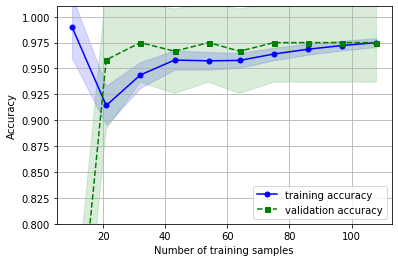


 k-NN Learning Curve


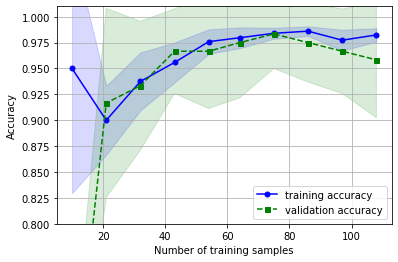

In [6]:
#Plot Learning Curve
print('GNB Learning Curve')
plot_learning_curves(pipe_gnb)
print('\n k-NN Learning Curve')
plot_learning_curves(pipe_knn)

Model Evaluation Original Model - Accuracy
GNB 0.95 +/- 0.05
k-NN 0.95 +/- 0.05




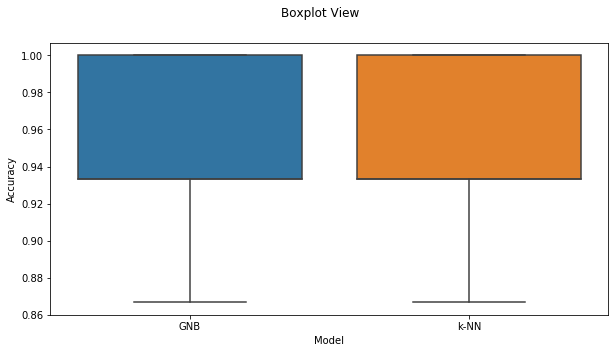

In [7]:
#Model Analysis - Original Model
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score

models=[]
models.append(('GNB',pipe_gnb))
models.append(('k-NN',pipe_knn))

#Model Evaluation
results =[]
names=[]
scoring ='accuracy'
print('Model Evaluation Original Model - Accuracy')
for name, model in models:
    rkf=RepeatedKFold(n_splits=10, n_repeats=5, random_state=100)
    cv_results = cross_val_score(model,x,y,cv=rkf,scoring=scoring)
    results.append(cv_results)
    names.append(name)
    print('{} {:.2f} +/- {:.2f}'.format(name,cv_results.mean(),cv_results.std()))
print('\n')

fig = plt.figure(figsize=(10,5))
fig.suptitle('Boxplot View')
ax = fig.add_subplot(111)
sns.boxplot(data=results)
ax.set_xticklabels(names)
plt.ylabel('Accuracy')
plt.xlabel('Model')
plt.show()

In [8]:
#Define Gridsearch Function

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix  

def Gridsearch_cv(model, params):
    
    #Cross-validation Function
    cv2=RepeatedKFold(n_splits=10, n_repeats=5, random_state=100)
        
    #GridSearch CV
    gs_clf = GridSearchCV(model, params, n_jobs=-1, cv=cv2)
    gs_clf = gs_clf.fit(x_train2, y_train)
    model = gs_clf.best_estimator_
    
    #Nested CV
    scoreACC = cross_val_score(gs_clf, x_2, y, 
                             scoring='accuracy', cv=5,
                             n_jobs= -1)
    
    scorePM = cross_val_score(gs_clf, x_2, y, 
                             scoring='precision_weighted', cv=5,
                             n_jobs= -1)
    
    scoreRM = cross_val_score(gs_clf, x_2, y, 
                             scoring='recall_weighted', cv=5,
                             n_jobs= -1)
    
    # Use best model and test data for final evaluation
    y_pred = model.predict(x_test2)

    #Identify Best Parameters to Optimize the Model
    bestpara=str(gs_clf.best_params_)
    
    #Output Heading
    print('Opimized Model')
    print('\nModel Name:',str(pipeline.named_steps['clf']))
        
    #Output Validation Statistics
    target_names=['setosa','versicolor','virginica']
    print('\nBest Parameters:',bestpara)
    print('\n', confusion_matrix(y_test,y_pred))  
    print('\n',classification_report(y_test,y_pred,target_names=target_names)) 
    print('\nNestedCV Accuracy(weighted) :{:0.2f} +/-{:0.2f} '.format(np.mean(scoreACC),np.std(scoreACC)))
    print('NestedCV Precision(weighted) :{:0.2f} +/-{:0.2f} '.format(np.mean(scorePM),np.std(scorePM)))
    print('NestedCV Recall(weighted) :{:0.2f} +/-{:0.2f} '.format(np.mean(scoreRM),np.std(scoreRM)))
    print('\n')

In [9]:
#Run Models

for pipeline, modelpara in zip(pipeline,modelpara):
    Gridsearch_cv(pipeline,modelpara)

Opimized Model

Model Name: GaussianNB(priors=None, var_smoothing=1e-09)

Best Parameters: {}

 [[10  0  0]
 [ 0  9  1]
 [ 0  1  9]]

               precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       0.90      0.90      0.90        10
   virginica       0.90      0.90      0.90        10

    accuracy                           0.93        30
   macro avg       0.93      0.93      0.93        30
weighted avg       0.93      0.93      0.93        30


NestedCV Accuracy(weighted) :0.95 +/-0.03 
NestedCV Precision(weighted) :0.96 +/-0.02 
NestedCV Recall(weighted) :0.95 +/-0.03 


Opimized Model

Model Name: KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

Best Parameters: {'clf__n_neighbors': 8}

 [[10  0  0]
 [ 0 10  0]
 [ 0  2  8]]

               precision    recall  f1-score   support

